## tsai Model Development with InceptionTime

https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb


https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb

In [1]:
from tsai.all import *
import sklearn.metrics as skm
my_setup()

os              : Linux-6.2.0-35-generic-x86_64-with-glibc2.35
python          : 3.9.16
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.1
cpu cores       : 6
threads per cpu : 2
RAM             : 62.44 GB
GPU memory      : [3.82] GB


### Functions

In [2]:

from sklearn.preprocessing import StandardScaler

def z_scores(df):
    """ Normalizing the values per each lab_parameter column using Z-scores (standardization)
    """
    # Separate the columns that should not be normalized (patient_id, lab_parameter, and target)
    non_normalize_cols = ['patient_id', 'lab_parameter', 'target']
    normalized_cols = [col for col in df.columns if col not in non_normalize_cols]

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Apply Z-score normalization to the numeric columns
    df[normalized_cols] = scaler.fit_transform(df[normalized_cols])

    return df

## Data preparation

In [3]:

import os
import pandas as pd
import numpy as np
from io import StringIO
from scipy.stats import mode  # Import the mode function from scipy.stats

# Read the list of unique patient IDs
dir_path = '//home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/03_dataset/'

## Read tarining set
# filename_tr = os.path.join(dir_path, 'zTrainset_raw-0_to_15_ts.csv')
filename_tr = os.path.join(dir_path, 'zzTrainset-0_to_15_ts.csv')
df_tr = pd.read_csv(filename_tr, sep=',', header=0)

## Apply z-scores
df_tr = z_scores(df_tr)
display(df_tr)


## Read validation set
# filename_Va = os.path.join(dir_path, 'zValidset_raw-0_to_15_ts.csv')
filename_Va = os.path.join(dir_path, 'zzValidset-0_to_15_ts.csv')
df_Va = pd.read_csv(filename_Va, sep=',', header=0)

## Apply z-scores
df_Va = z_scores(df_Va)
display(df_Va)

,patient_id,lab_parameter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,target
0,1000010,ALAT,0.694269,-0.351996,-0.354803,0.794460,0.603308,-0.305265,0.432470,-0.301232,-0.264508,-0.261451,-0.268672,-0.238228,-0.242892,-0.224397,-0.220168,-0.186903,0
1,1000010,ASAT,-0.415085,-0.351996,-0.354803,-0.324288,-0.308001,-0.305265,-0.288069,-0.301232,-0.264508,-0.261451,-0.268672,-0.238228,-0.242892,-0.224397,-0.220168,-0.186903,0
2,1000010,Basophile,-0.402334,-0.351996,-0.354803,-0.309371,-0.308001,-0.305265,-0.288069,-0.301232,-0.264508,-0.261451,-0.268672,-0.238228,-0.242892,-0.224397,-0.220168,-0.186903,0
3,1000010,Bicarbonat Std.,0.060534,0.130636,0.045588,0.072921,0.141302,0.130609,0.158021,0.153590,0.197618,0.261727,0.222893,0.300477,0.244630,0.299105,0.303331,0.315189,0
4,1000010,Bicarbonat akt.,0.089498,0.180075,0.078701,0.108721,0.136055,0.128114,0.143962,0.146004,0.212709,0.259360,0.217996,0.295053,0.245274,0.306305,0.303331,0.317574,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6645,1001355,Thrombozyten,1.905632,-0.351996,-0.354803,2.823123,-0.308001,-0.305265,4.790853,-0.301232,-0.264508,-0.261451,-0.268672,-0.238228,-0.242892,-0.224397,-0.220168,-0.186903,1
6646,1001355,aPTT,0.049058,-0.351996,-0.354803,-0.324288,-0.308001,-0.305265,-0.288069,-0.301232,-0.264508,-0.261451,-0.268672,-0.238228,-0.242892,-0.224397,-0.220168,-0.186903,1
6647,1001355,eGFR nach CKD-EPI,0.503001,-0.351996,-0.354803,1.018210,-0.308001,-0.305265,1.363899,-0.301232,-0.264508,-0.261451,1.512715,-0.238228,-0.242892,-0.224397,-0.220168,-0.186903,1
6648,1001355,pH,-0.306623,-0.351996,-0.231704,-0.324288,-0.308001,-0.305265,-0.288069,-0.301232,-0.121678,-0.261451,-0.268672,-0.238228,-0.242892,-0.224397,-0.220168,-0.186903,1


,patient_id,lab_parameter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,target
0,1000592,ALAT,-0.180331,-0.412823,-0.034661,-0.346474,-0.2849,-0.281961,-0.311204,-0.287286,-0.2516,-0.252592,-0.246743,-0.209955,-0.179525,-0.165618,-0.166864,-0.167525,1
1,1000592,ASAT,-0.061520,-0.412823,-0.386451,-0.346474,-0.2849,-0.281961,-0.311204,-0.287286,-0.2516,-0.252592,-0.246743,-0.209955,-0.179525,-0.165618,-0.166864,-0.167525,1
2,1000592,Basophile,-0.417773,-0.412823,-0.386451,-0.346474,-0.2849,-0.281961,-0.311204,-0.287286,-0.2516,-0.252592,-0.246743,-0.209955,-0.179525,-0.165618,-0.166864,-0.167525,1
3,1000592,Bicarbonat Std.,-0.429833,-0.412823,-0.386451,-0.346474,-0.2849,-0.281961,-0.311204,-0.287286,-0.2516,-0.252592,-0.246743,-0.209955,-0.179525,-0.165618,-0.166864,-0.167525,1
4,1000592,Bicarbonat akt.,-0.429833,-0.412823,-0.386451,-0.346474,-0.2849,-0.281961,-0.311204,-0.287286,-0.2516,-0.252592,-0.246743,-0.209955,-0.179525,-0.165618,-0.166864,-0.167525,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,1001065,Thrombozyten,0.615699,1.262892,0.823709,-0.346474,-0.2849,-0.281961,-0.311204,-0.287286,-0.2516,-0.252592,-0.246743,-0.209955,-0.179525,-0.165618,-0.166864,-0.167525,0
731,1001065,aPTT,0.033528,-0.412823,-0.386451,-0.346474,-0.2849,-0.281961,-0.311204,-0.287286,-0.2516,-0.252592,-0.246743,-0.209955,-0.179525,-0.165618,-0.166864,-0.167525,0
732,1001065,eGFR nach CKD-EPI,0.972130,1.204095,1.189571,-0.346474,-0.2849,-0.281961,-0.311204,-0.287286,-0.2516,-0.252592,-0.246743,-0.209955,-0.179525,-0.165618,-0.166864,-0.167525,0
733,1001065,pH,-0.330149,-0.288724,-0.267831,-0.346474,-0.2849,-0.281961,-0.311204,-0.287286,-0.2516,-0.252592,-0.246743,-0.209955,-0.179525,-0.165618,-0.166864,-0.167525,0


### Convert dataframe to tensors

In [4]:

# def get_tensor(df, sample_col, feat_col, data_cols, y_func=None):
def get_tensor(df):
    def y_func(o): return mode(o, axis=1, keepdims=True).mode
    # X, y = df2xy(df, sample_col='patient_id', feat_col='lab_parameter', target_col=['target'], data_cols=['0', '1', '2', '3', '4', '5', '6', '7'], y_func=y_func)
    X, y = df2xy(df, sample_col='patient_id', feat_col='lab_parameter', target_col=['target'], data_cols=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'], y_func=y_func)
    print(X.shape, y.shape)
    return X, y


## Get the tensors from the training set
X_tr, y_tr = get_tensor(df_tr)

## Get the tensors from the validation set
X_va, y_va = get_tensor(df_Va)


##
X, y, splits = combine_split_data([X_tr, X_va], [y_tr, y_va])

(190, 35, 16) (190,)
(21, 35, 16) (21,)


In [5]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# dsets = TSDatasets(X, y, tfms=tfms, inplace=True)
display(dsets)

(#211) [(TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:35, len:16, device=cpu, dtype=torch.float32), TensorCategory(0))] ...]

In [6]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
# dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], num_workers=0)

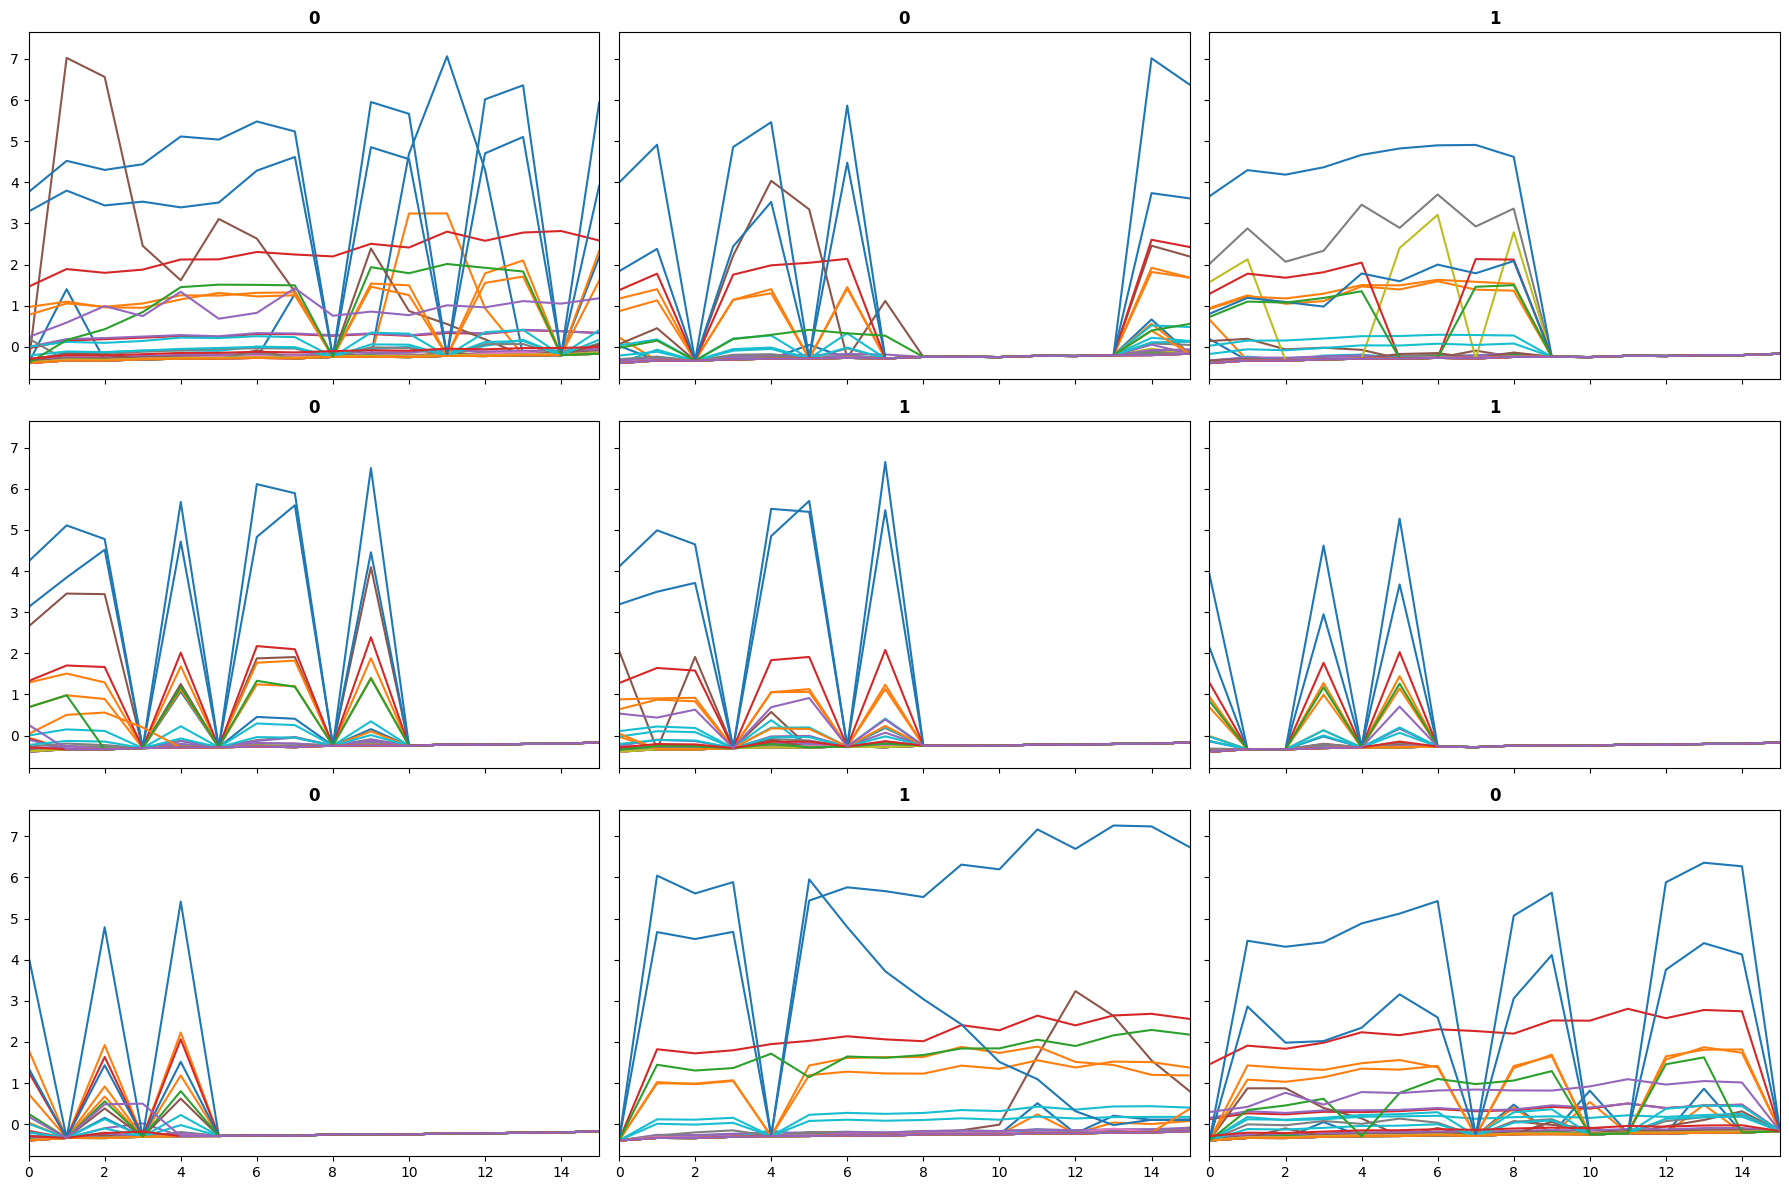

In [7]:
# dls.show_batch(sharey=True)

## Add ledgend to the dls.show_batch
dls.show_batch(sharey=True)

In [8]:
# model = InceptionTimePlus(dls.vars, dls.c)
# learn = Learner(dls, model, metrics=accuracy)
# learn.save('stage0')

# Create the InceptionTime model
model = InceptionTime(dls.vars, dls.c)
# learn = Learner(dls, model, metrics=F1ScoreMulti(average='macro'))
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

SuggestedLRs(valley=0.0004786300996784121)

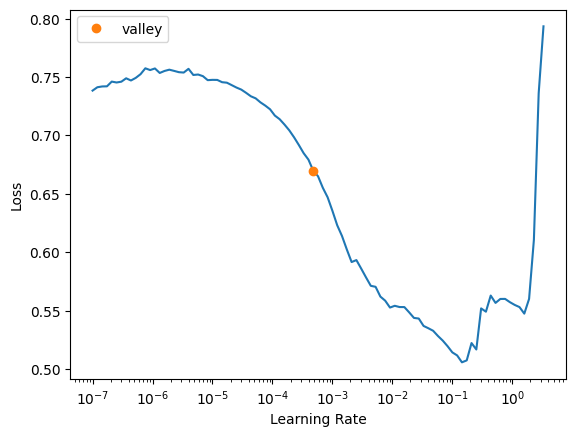

In [9]:
learn.load('stage0')
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.743808,0.690499,0.571429,00:03
1,0.722840,0.689623,0.523810,00:02
2,0.701601,0.689481,0.476190,00:01
3,0.681900,0.689574,0.523810,00:02
4,0.666546,0.689015,0.571429,00:02
5,0.645011,0.687363,0.523810,00:03
6,0.623716,0.684199,0.571429,00:04
7,0.613108,0.679359,0.571429,00:04
8,0.594421,0.673390,0.619048,00:02
9,0.576511,0.665107,0.571429,00:02


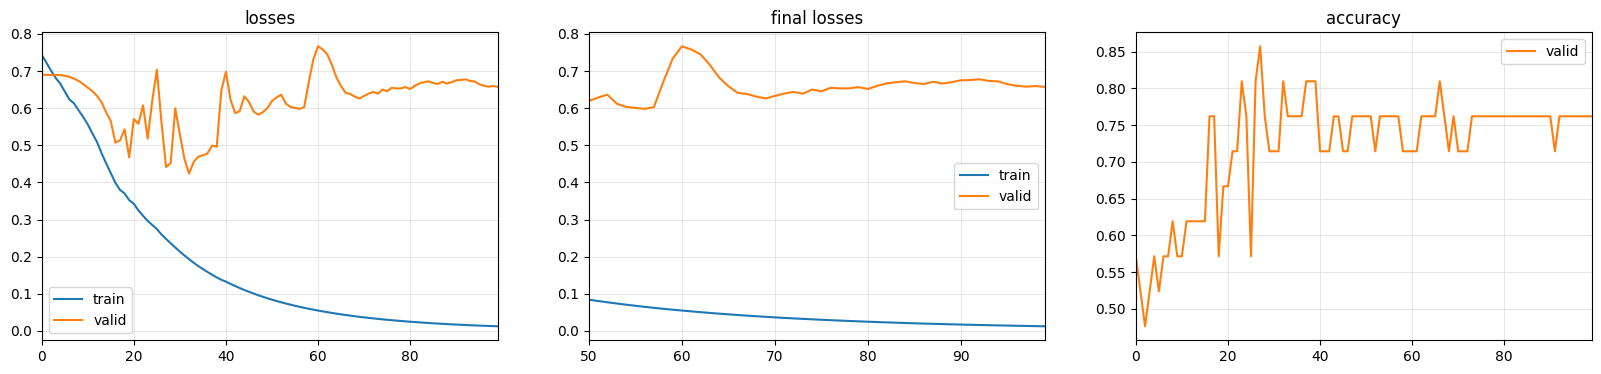

In [10]:
learn.fit_one_cycle(100, lr_max=1e-3)
learn.save('stage1')
learn.recorder.plot_metrics()

In [ ]:
# learn.recorder.plot_metrics()

### To save everything you can use a convenience function I've created that saves the learner with the model, the data and the opt function status:

In [11]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

In [ ]:
## As soon as we've done this, we can end the session, and continue at any time in the future.
## Let's simulate that we need to end the session now:
del learn, dsets, dls

In [12]:
## Next time we go back to work, we'll need to reload the datasets and learner (with the same status we had):

learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:21, vars:35, len:16, device=cpu, dtype=torch.float32),
 TensorCategory([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [13]:

valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

# ## Duplicate in 300x valid_probas, valid_targets, valid_preds 
# valid_probas = np.repeat(valid_probas, 100, axis=0)
# valid_targets = np.repeat(valid_targets, 100, axis=0)
# valid_preds = np.repeat(valid_preds, 100, axis=0)

# valid_probas, valid_targets, valid_preds

(tensor([[1.1423e-03, 9.9886e-01],
         [4.3338e-02, 9.5666e-01],
         [3.9695e-01, 6.0305e-01],
         [9.8312e-01, 1.6875e-02],
         [5.6607e-03, 9.9434e-01],
         [7.6192e-01, 2.3808e-01],
         [7.5336e-02, 9.2466e-01],
         [9.2530e-01, 7.4696e-02],
         [1.9701e-01, 8.0299e-01],
         [9.9708e-01, 2.9250e-03],
         [9.9668e-01, 3.3188e-03],
         [8.2722e-01, 1.7278e-01],
         [9.8862e-01, 1.1383e-02],
         [9.9355e-01, 6.4526e-03],
         [3.7441e-01, 6.2559e-01],
         [9.9934e-01, 6.5967e-04],
         [6.3993e-01, 3.6007e-01],
         [9.9969e-01, 3.0807e-04],
         [7.5061e-01, 2.4939e-01],
         [8.6735e-01, 1.3265e-01],
         [6.2864e-02, 9.3714e-01]]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]))

In [14]:
(valid_targets == valid_preds).float().mean()

tensor(0.7619)

In [ ]:
# learn.show_results()

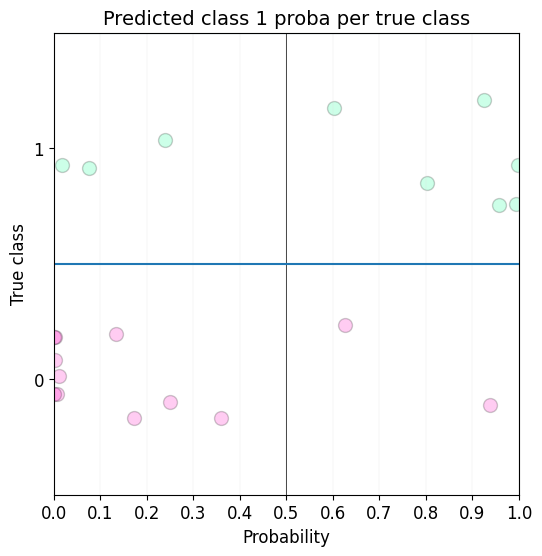

In [15]:
learn.show_probas()

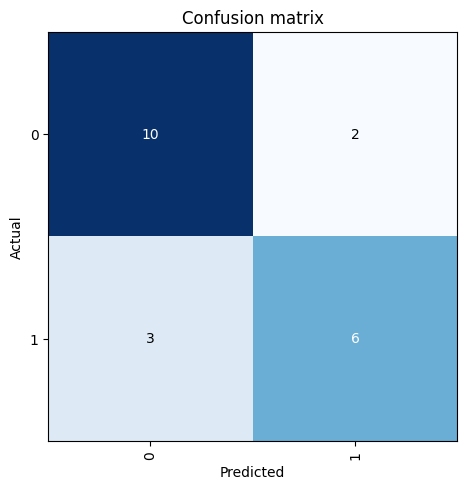

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Get the deep latent representation

In [28]:

from tsai.all import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


# Load the saved model weights (if available)
try:
    learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
except FileNotFoundError:
    raise FileNotFoundError("Could not load the learner. Make sure the export files are in the correct path.")

dls = learn.dls
valid_dl = dls.valid


# Define a function to get deep latent representations
def get_deep_latent_representation(learner, dataloader):
    learner.model.eval()
    latent_representations = []

    with torch.no_grad():
        for xb, _ in dataloader:
            # Extract the deep latent representation from the model
            model_output = learn.model(xb)

            # Handle different model output structures
            if isinstance(model_output, (list, tuple)) and len(model_output) > 0:
                # latent_representation = model_output[0]  # Access the latent representation part of the model output
                latent_representation = model_output[-1]  # Access the latent representation part of the model output
            else:
                latent_representation = model_output

            latent_representations.append(latent_representation.cpu().numpy())

    return np.vstack(latent_representations)

# Get the deep latent representation for the validation set
latent_representations = get_deep_latent_representation(learn, dls.valid)
print("Latent representations:", latent_representations)
print("Latent representations shape:", latent_representations.shape)

# Apply t-SNE for visualization with a lower perplexity value
tsne = TSNE(n_components=2, perplexity=5, n_iter=250)
try:
    latent_representations_2d = tsne.fit_transform(latent_representations)
except ValueError as e:
    raise ValueError(f"Error in t-SNE computation: {e}")


# # Visualize the latent representations without colors
# plt.figure(figsize=(10, 8))
# plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1])
# plt.title("t-SNE Visualization of Deep Latent Representations")
# plt.show()


# # Get the labels for each sample
# labels = dls.valid.items['target'].values
# print("labels", labels.shape)

# # Visualize the latent representations with colors
# plt.figure(figsize=(10, 8))
# plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=labels)
# plt.title("t-SNE Visualization of Deep Latent Representations")
# plt.show()


# Get the labels for each sample
labels = dls.valid.items[1].numpy()


# Create a color map for unique labels
unique_labels = np.unique(labels)
num_labels = len(unique_labels)
color_map = plt.cm.viridis(np.linspace(0, 1, num_labels))

# Assign colors to data points based on their labels
colors = [color_map[np.where(unique_labels == label)[0][0]] for label in labels]

# Visualize the latent representations with colors
plt.figure(figsize=(10, 8))
plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=colors)
plt.title("t-SNE Visualization of Deep Latent Representations")
plt.colorbar()
plt.show()

Latent representations: [[-2.8251047   3.948455  ]
 [-1.3249767   1.7694553 ]
 [ 0.15192409  0.5701154 ]
 [ 2.9266746  -1.1382048 ]
 [-2.061029    3.1075065 ]
 [ 0.9822214  -0.18101652]
 [-0.40210664  2.1053607 ]
 [ 1.7089288  -0.8077735 ]
 [-0.1450451   1.2600145 ]
 [ 3.7802167  -2.0513268 ]
 [ 3.5781348  -2.1267042 ]
 [ 1.2218345  -0.3441837 ]
 [ 2.6972802  -1.7669346 ]
 [ 3.0461211  -1.9906846 ]
 [ 0.10062344  0.61396545]
 [ 4.2136717  -3.1094427 ]
 [ 0.6295547   0.05449175]
 [ 4.808598   -3.276281  ]
 [ 0.7892724  -0.31257182]
 [ 1.4484482  -0.42931435]
 [-1.0962427   1.6056094 ]]
Latent representations shape: (21, 2)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# from tsai.all import *
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Load the saved model weights (if available)
# try:
#     learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
# except FileNotFoundError:
#     raise FileNotFoundError("Could not load the learner. Make sure the export files are in the correct path.")

# dls = learn.dls
# # valid_dl = dls.valid
# valid_dl = dls.train
# b = next(iter(valid_dl))
# print("Sample batch from the validation data loader:", b)

# # Define a function to get deep latent representations
# def get_deep_latent_representation(learner, dataloader):
#     learner.model.eval()
#     latent_representations = []

#     with torch.no_grad():
#         for xb, _ in dataloader:
#             # Extract the deep latent representation from the model
#             model_output = learn.model(xb)

#             # Handle different model output structures
#             if isinstance(model_output, (list, tuple)) and len(model_output) > 0:
#                 # latent_representation = model_output[0]  # Access the latent representation part of the model output
#                 latent_representation = model_output[-1]  # Access the latent representation part of the model output
#             else:
#                 latent_representation = model_output

#             latent_representations.append(latent_representation.cpu().numpy())

#     return np.vstack(latent_representations)

# # Get the deep latent representation for the validation set
# latent_representations = get_deep_latent_representation(learn, dls.valid)
# print("Latent representations:", latent_representations)
# print("Latent representations shape:", latent_representations.shape)



# # Apply t-SNE for visualization
# # tsne = TSNE(n_components=2, perplexity=30, n_iter=300)


# # Apply t-SNE for visualization with a lower perplexity value
# tsne = TSNE(n_components=2, perplexity=5, n_iter=250)
# # latent_representations_2d = tsne.fit_transform(latent_representations)
# try:
#     latent_representations_2d = tsne.fit_transform(latent_representations)
# except ValueError as e:
#     raise ValueError(f"Error in t-SNE computation: {e}")

# # # Assuming y contains your labels
# # y = valid_targets.cpu().numpy()  # Convert y to a NumPy array

# # # Create a colormap for the labels
# # unique_labels = np.unique(y)
# # num_labels = len(unique_labels)
# # color_map = plt.cm.viridis(np.linspace(0, 1, num_labels))

# # # Assign a color to each label
# # colors = [color_map[label] for label in y]

# # # Visualize the latent representations with colors
# # plt.figure(figsize=(10, 8))
# # plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=colors)
# # plt.title("t-SNE Visualization of Deep Latent Representations")
# # plt.colorbar()
# # plt.show()


# # Assuming y contains your labels
# y = valid_targets.cpu().numpy()  # Convert y to a NumPy array

# # Create a colormap for the labels
# unique_labels = np.unique(y)
# num_labels = len(unique_labels)
# color_map = plt.cm.viridis(np.linspace(0, 1, num_labels))

# # Assign a color to each label
# colors = [color_map[label] for label in y]

# # Visualize the latent representations with colors
# plt.figure(figsize=(10, 8))
# plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=colors)
# plt.title("t-SNE Visualization of Deep Latent Representations")
# plt.colorbar()
# plt.show()

In [ ]:
# from tsai.all import *
# import sklearn.metrics as skm
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Load the saved model weights (if available)
# learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
# dls = learn.dls
# valid_dl = dls.valid
# b = next(iter(valid_dl))
# print("b", b)

# # Define a function to get deep latent representations
# def get_deep_latent_representation(learner, dataloader):
#     learner.model.eval()
#     latent_representations = []

#     with torch.no_grad():
#         for xb, yb in dataloader:
#             # Extract the deep latent representation from the model
#             model_output = learn.model(xb)
#             latent_representation = model_output[0]  # Access the latent representation part of the model output
#             latent_representations.append(latent_representation.cpu().numpy())

#     return np.vstack(latent_representations)

# # Get the deep latent representation for the validation set
# latent_representations = get_deep_latent_representation(learn, dls.valid)


# # # Apply t-SNE for visualization
# # tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# # latent_representations_2d = tsne.fit_transform(latent_representations)

# # Apply t-SNE for visualization with an even lower perplexity value
# tsne = TSNE(n_components=2, perplexity=1, n_iter=250)
# latent_representations_2d = tsne.fit_transform(latent_representations)

# # Visualize the latent representations
# plt.figure(figsize=(10, 8))
# plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=y, cmap='viridis')
# plt.title("t-SNE Visualization of Deep Latent Representations")
# plt.colorbar()
# plt.show()

### Define splits

Transformed a multivariate time series with 966 time steps and 7 features (excluding the datetime) into:

- 803 input samples, with 7 features and 104 historical time steps
- 803 input samples, with 7 features and 60 future time steps.

In [ ]:
fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

### Apply a sliding window

- Here is approached the time series forecasting task as a supervised learning problem. 
- tsai requires that both inputs and outputs have the following shape:
    - [# samples x #features #steps]
- To get those inputs and outputs we're going to use a function called prepare_forecasting_data that applies a sliding window along the dataframe.
To use prepare_forecasting_data we need to define some settings

In [ ]:
x_vars = df.columns[2:-1]
y_vars = df.columns[-1:]

display(x_vars)
display(y_vars)

In [ ]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape